# Fine-tune pre-trained PGGAN generator

We fine-tune to to learn an approximation of the target model’s training data distribution based on its internal activations (BatchNorm statistics, features) that are contained with the model's `state_dict`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/COGS_402/Code/Local

/content/drive/MyDrive/COGS_402/Code/Local


In [3]:
%ls

cnn_feats_finetuned_gen.pt    finetune.ipynb  target_models/
cnn_finetuned_gen_classes.pt  pggan/          vis/
cnn_finetuned_gen.pt          __pycache__/
cnn_overfit_finetuned_gen.pt  recons/


In [7]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 58.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # COLAB
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # LOCAL
print(device)

cuda


In [5]:
# Load PGGAN

ckpt = torch.load("pggan/final_generator_model.pth", map_location=device)
sd = ckpt["state_dict"]

# Pull out channel sizes from ScaleBlocks
depths = []
i = 0
while True:
    key = f"ScaleBlocks.{i}.convolv.0.module.weight"
    if key not in sd:
        break
    out_ch, in_ch, _, _ = sd[key].shape
    depths.append(out_ch)
    i += 1

assert len(depths) > 0, "No ScaleBlocks found in checkpoint"
print("Generator depths:", depths)

Generator depths: [512, 512, 512, 256, 128, 64, 32, 16]


In [6]:
import sys
sys.path.append('/content') # COLAB
# sys.path.append('..') # LOCAL
from pggan.network import ProGenerator

# Initialize generator
initial_depth = depths[0]
gan = ProGenerator(z_dim=512, channel_depth=initial_depth, out_channels=3).to(device)

for d in depths:
    gan.incrementdepth(d)

# Load generator checkpoint weights
gan.load_state_dict(sd, strict=False)

<All keys matched successfully>

## CNN

In [7]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

cnn = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
features = cnn.fc.in_features
cnn.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(features, 1) # binary classification
)
cnn.load_state_dict(torch.load('target_models/models/chest2d_cnn_cpu.pt'))
cnn.eval().to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.amp import autocast, GradScaler

class FineTuneGeneratorResNet:
    def __init__(self, generator, model, device='cpu'):
        self.G = generator.train().to(device)
        self.model = model.eval().to(device)
        self.device = device

        # Select layers
        self.bn_layers = [n for n, m in self.model.named_modules() if isinstance(m, nn.BatchNorm2d)]
        self.feature_layers = ['layer4.1.conv2']
        self.hooked = list(set(self.bn_layers + self.feature_layers))
        self.activations = {}

        # Register hooks
        for name, module in self.model.named_modules():
            if name in self.hooked:
                module.register_forward_hook(self._make_hook(name))

        # Store BN stats
        self.bn_targets = {
            name: {
                'mean': m.running_mean.clone().detach().to(device),
                'var': m.running_var.clone().detach().to(device)
            }
            for name, m in self.model.named_modules() if isinstance(m, nn.BatchNorm2d)
        }

    def _make_hook(self, name):
        def hook(module, input, output):
            self.activations[name] = output
        return hook

    @staticmethod
    def total_variation(x):
        # Encourage spatial smoothness
        dh = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]).mean()
        dw = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]).mean()
        return dh + dw

    def train(self, steps=3000, z_dim=512, batch_size=16, lr=1e-5,
                w_bn=1.0, w_feat=1.0, w_tv=1e-5):

        optimizer = optim.Adam(self.G.parameters(), lr=lr)
        scaler=GradScaler()

        for step in range(1, steps+1):
            self.activations.clear()
            optimizer.zero_grad()

            # Randomly initialize latent
            z = torch.randn(batch_size, z_dim, device=self.device)

            with autocast('cuda'):
              # Pass through GAN
              imgs = self.G(z)
              imgs_resized = F.interpolate(imgs, size=(224, 224), mode='bilinear', align_corners=False) # target model expects 224x224

              # Forward through target model
              _ = self.model(imgs)

              loss = 0.0

              # BN matching
              for name in self.bn_layers:
                  feat = self.activations.get(name)
                  if feat is None:
                      continue
                  mean = feat.mean((0, 2, 3))
                  var = feat.var((0, 2, 3), unbiased=False)
                  target = self.bn_targets[name]
                  loss += w_bn * (F.mse_loss(mean, target['mean']) + F.mse_loss(var, target['var']))

              # Feature stats matching
              for name in self.feature_layers:
                  feat = self.activations.get(name)
                  if feat is None:
                      continue
                  mean_f = feat.mean((0, 2, 3))
                  var_f = feat.var((0, 2, 3), unbiased=False)
                  loss += w_feat * ((mean_f ** 2).mean() + ((var_f - 1) ** 2).mean())

              # Total variation
              loss += w_tv * self.total_variation(imgs)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if step % 100 == 0 or step == 1:
                print(f"Step {step}/{steps}, Loss: {loss.item():.4f}")

        return self.G

In [9]:
gen = FineTuneGeneratorResNet(generator=gan, model=cnn, device=device)
trained_gen = gen.train(steps=2500, batch_size=8, lr=1e-5)

Step 1/2500, Loss: 14.9184
Step 100/2500, Loss: 14.2092
Step 200/2500, Loss: 13.3296
Step 300/2500, Loss: 13.1039
Step 400/2500, Loss: 12.5217
Step 500/2500, Loss: 12.1788
Step 600/2500, Loss: 11.3650
Step 700/2500, Loss: 11.3805
Step 800/2500, Loss: 10.9954
Step 900/2500, Loss: 10.6765
Step 1000/2500, Loss: 10.5805
Step 1100/2500, Loss: 10.2031
Step 1200/2500, Loss: 9.8599
Step 1300/2500, Loss: 9.9218
Step 1400/2500, Loss: 9.6037
Step 1500/2500, Loss: 9.5822
Step 1600/2500, Loss: 9.4888
Step 1700/2500, Loss: 9.4882
Step 1800/2500, Loss: 9.5378
Step 1900/2500, Loss: 9.4279
Step 2000/2500, Loss: 9.3822
Step 2100/2500, Loss: 9.3806
Step 2200/2500, Loss: 9.3932
Step 2300/2500, Loss: 9.3449
Step 2400/2500, Loss: 9.3058
Step 2500/2500, Loss: 9.3123


In [10]:
torch.save(trained_gen.state_dict(), "cnn_finetuned_gen.pt")

In [ ]:
gan.load_state_dict(torch.load('cnn_finetuned_gen.pt'))

<All keys matched successfully>

In [ ]:
def sample_images(generator, z_dim=512, num_samples=10, batch_size=8, device='cuda', target_size=(224, 224)):
    generator.eval()
    all_imgs = []

    with torch.no_grad():
        for _ in range((num_samples + batch_size - 1) // batch_size):
            z = torch.randn(batch_size, z_dim, device=device)
            imgs = generator(z)

            # Resize to target size
            imgs = F.interpolate(imgs, size=target_size, mode='bilinear', align_corners=False)
            
            all_imgs.append(imgs)

    return torch.cat(all_imgs, dim=0)[:num_samples]

In [12]:
candidates = sample_images(gan, z_dim=512, num_samples=100, batch_size=2, device=device)

In [15]:
# Save tensor

torch.save(candidates, 'cnn_cand.pt')

In [ ]:
candidates = torch.load('cnn_cand.pt')

In [8]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(samples, nrow=4, title="Generated Samples"):
  samples_gray = samples.mean(dim=1, keepdim=True) # average channels for grayscale
  grid = vutils.make_grid(samples_gray, nrow=nrow, normalize=True, scale_each=True)
  img_np = grid.permute(1, 2, 0).cpu().numpy()

  plt.figure(figsize=(8,8))
  plt.imshow(img_np)
  plt.axis('off')
  plt.title(title)
  plt.show()

  return samples

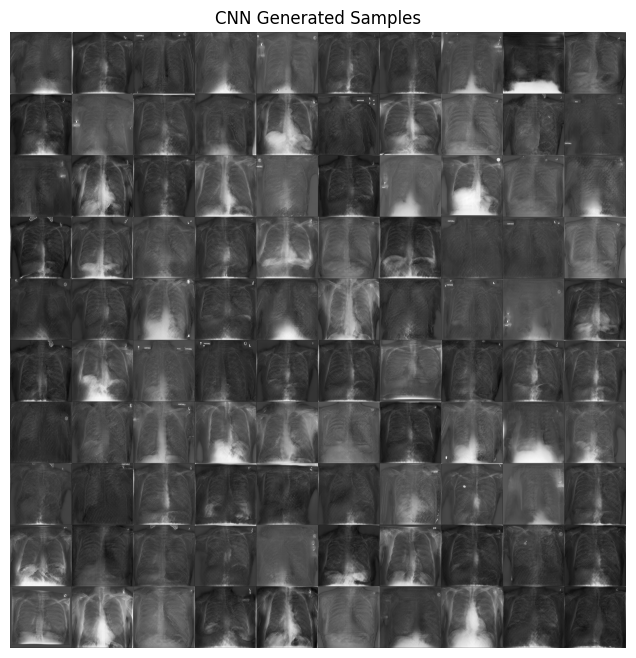

In [14]:
images = show_images(candidates, nrow=10, title="CNN Generated Samples")

To compare the fine-tuned generator's output distribution and the CNN's true distribution, we use Frechet Inception Distance (FID) to measure the similarity between the two distributions in feature space.

FID computes the distance between two multivariate Gaussians fit to activations from the CNN.

In [ ]:
# Setup feature extractor

import torch
import torch.nn as nn
import numpy as np
from scipy import linalg

def get_features_hook(name, activations_dict):
    def hook(model, input, output):
        activations_dict[name] = output.detach()
    return hook

cnn.eval()
activations = {}

# Register hook on one feature layer of the CNN
feature_layer = 'layer4'
for name, module in cnn.named_modules():
    if name == feature_layer:
        module.register_forward_hook(get_features_hook(name, activations))
        break

In [ ]:
# Extract features for a dataset

def extract_features(model, dataloader, device='cpu'):
    model.eval()
    feats = []
    with torch.no_grad():
        for (imgs,) in dataloader:
            imgs = imgs.to(device)
            _ = model(imgs)
            f = activations[feature_layer]
            f = f.view(f.size(0), -1)
            feats.append(f.cpu())
    return torch.cat(feats)

In [ ]:
# Compute Frechet distance

def compute_frechet(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)

    if not np.isfinite(covmean).all():
        covmean = covmean.real + eps * np.eye(sigma1.shape[0])

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    dist = (diff @ diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return dist

In [ ]:
# Setup target model data (CheXpert)
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset

cnn_files = sorted(Path(".").glob("target_models/images/cnn/batch_*.pt"))

all_images = []

for f in cnn_files:
    data = torch.load(f)
    all_images.append(data["images"])

target_images = torch.cat(all_images, dim=0)
target_dataset = TensorDataset(target_images)
target_loader = DataLoader(target_dataset, batch_size=8, shuffle=False)

In [ ]:
# Setup generator data (reconstructed samples)
from torch.utils.data import DataLoader, TensorDataset

gen_dataset = TensorDataset(candidates)
gen_loader = DataLoader(gen_dataset, batch_size=8, shuffle=False)

In [ ]:
# Extract from target data
target_feats = extract_features(cnn, target_loader, device)
mu_target = target_feats.mean(0).numpy()
sigma_target = np.cov(target_feats.T.numpy())

In [ ]:
# Extract from generator samples
gen_feats = extract_features(cnn, gen_loader, device)
mu_gen = gen_feats.mean(0).numpy()
sigma_gen = np.cov(gen_feats.T.numpy())

In [ ]:
# Compute FID
fid = compute_frechet(mu_target, sigma_target, mu_gen, sigma_gen)
print(f"CNN FID: {fid:.2f}")

## CNN with classes

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.amp import autocast, GradScaler
import torch.fft

class FineTuneGeneratorResNetClasses:
    def __init__(self, generator, model, device='cpu'):
        self.G = generator.train().to(device)
        self.model = model.eval().to(device)
        self.device = device

        # Select layers
        self.bn_layers = [n for n, m in self.model.named_modules() if isinstance(m, nn.BatchNorm2d)]
        self.feature_layers = ['layer4.1.conv2']
        self.hooked = list(set(self.bn_layers + self.feature_layers))
        self.activations = {}

        # Register hooks
        for name, module in self.model.named_modules():
            if name in self.hooked:
                module.register_forward_hook(self._make_hook(name))

        # Store BN stats
        self.bn_targets = {
            name: {
                'mean': m.running_mean.clone().detach().to(device),
                'var': m.running_var.clone().detach().to(device)
            }
            for name, m in self.model.named_modules() if isinstance(m, nn.BatchNorm2d)
        }

    def _make_hook(self, name):
        def hook(module, input, output):
            self.activations[name] = output
        return hook

    @staticmethod
    def total_variation(x):
        # Encourage spatial smoothness
        dh = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]).mean()
        dw = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]).mean()
        return dh + dw

    def train(self, steps=3000, z_dim=512, batch_size=16, lr=1e-5,
                w_bn=1.0, w_feat=1.0, w_tv=1e-5, w_logits=1.0):

        optimizer = optim.Adam(self.G.parameters(), lr=lr)
        scaler=GradScaler()

        for step in range(1, steps+1):
            self.activations.clear()
            optimizer.zero_grad()

            # Randomly initialize latent
            z = torch.randn(batch_size, z_dim, device=self.device)
            # Chunk into 2 classes for binary classification
            z0, z1 = z.chunk(2)

            with autocast('cuda'):
              # Pass through GAN
              imgs0 = self.G(z0)
              imgs1 = self.G(z1)
              imgs = torch.cat([imgs0, imgs1], dim=0)
              imgs_resized = F.interpolate(imgs, size=(224, 224), mode='bilinear', align_corners=False) # target model expects 224x224

              # Forward through target model
              outputs = self.model(imgs_resized)

              loss = 0.0

              # BN matching
              for name in self.bn_layers:
                  feat = self.activations.get(name)
                  if feat is None:
                      continue
                  mean = feat.mean((0, 2, 3))
                  var = feat.var((0, 2, 3), unbiased=False)
                  target = self.bn_targets[name]
                  loss += w_bn * (F.mse_loss(mean, target['mean']) + F.mse_loss(var, target['var']))

              # Feature stats matching
              for name in self.feature_layers:
                  feat = self.activations.get(name)
                  if feat is None:
                      continue
                  mean_f = feat.mean((0, 2, 3))
                  var_f = feat.var((0, 2, 3), unbiased=False)
                  loss += w_feat * ((mean_f ** 2).mean() + ((var_f - 1) ** 2).mean())

              # Logit matching loss (max confidence for each class)
              logits0 = outputs[:batch_size // 2].view(-1)
              logits1 = outputs[batch_size // 2:].view(-1)

              target0 = torch.zeros_like(logits0) # Encourage 0s for first half, 1s for second half
              target1 = torch.ones_like(logits1)
              logit_loss = F.binary_cross_entropy_with_logits(logits0, target0) + \
                          F.binary_cross_entropy_with_logits(logits1, target1)

              loss += w_logits * logit_loss

              # Total variation
              loss += w_tv * self.total_variation(imgs)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if step % 100 == 0 or step == 1:
                print(f"Step {step}/{steps}, Loss: {loss.item():.4f}")

        return self.G

In [17]:
gen = FineTuneGeneratorResNetClasses(generator=gan, model=cnn, device=device)
trained_gen = gen.train(steps=2500, batch_size=8, lr=1e-5)

Step 1/2500, Loss: 10.8160
Step 100/2500, Loss: 10.8505
Step 200/2500, Loss: 10.7583
Step 300/2500, Loss: 10.6938
Step 400/2500, Loss: 10.8180
Step 500/2500, Loss: 10.7561
Step 600/2500, Loss: 10.4907
Step 700/2500, Loss: 10.4256
Step 800/2500, Loss: 10.5095
Step 900/2500, Loss: 10.2432
Step 1000/2500, Loss: 10.1516
Step 1100/2500, Loss: 10.2869
Step 1200/2500, Loss: 10.2272
Step 1300/2500, Loss: 10.3787
Step 1400/2500, Loss: 10.1718
Step 1500/2500, Loss: 9.9415
Step 1600/2500, Loss: 10.3895
Step 1700/2500, Loss: 10.3135
Step 1800/2500, Loss: 10.4150
Step 1900/2500, Loss: 10.3308
Step 2000/2500, Loss: 10.2193
Step 2100/2500, Loss: 10.0035
Step 2200/2500, Loss: 9.9223
Step 2300/2500, Loss: 10.1706
Step 2400/2500, Loss: 10.2550
Step 2500/2500, Loss: 10.4090


In [18]:
torch.save(trained_gen.state_dict(), "cnn_finetuned_gen_classes.pt")

In [ ]:
gan.load_state_dict(torch.load('cnn_finetuned_gen_classes.pt'))

<All keys matched successfully>

In [19]:
candidates = sample_images(gan, z_dim=512, num_samples=100, device=device)

In [21]:
torch.save(candidates, 'cnn_classes_cand.pt')

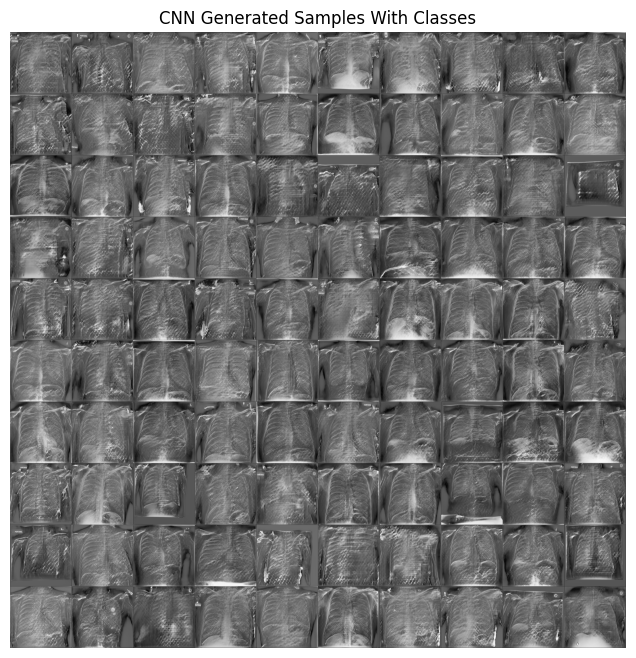

In [20]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(samples, nrow=4, title="Generated Samples"):
  samples_gray = samples.mean(dim=1, keepdim=True) # average channels for grayscale
  grid = vutils.make_grid(samples_gray, nrow=nrow, normalize=True, scale_each=True)
  img_np = grid.permute(1, 2, 0).cpu().numpy()

  plt.figure(figsize=(8,8))
  plt.imshow(img_np)
  plt.axis('off')
  plt.title(title)
  plt.show()

  return samples

images = show_images(candidates, nrow=10, title="CNN Generated Samples With Classes")

## Overfit CNN

In [10]:
from torchvision.models import resnet18, ResNet18_Weights
import torch
import torch.nn as nn

cnn_overfit = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
features = cnn_overfit.fc.in_features
cnn_overfit.fc = nn.Linear(features, 1)
cnn_overfit.load_state_dict(torch.load('target_models/models/chest2d_cnn_overfit_cpu.pt'))
cnn_overfit.eval().to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
gen_cnn_overfit = FineTuneGeneratorResNetClasses(generator=gan, model=cnn_overfit, device=device)
trained_gen_cnn_overfit = gen_cnn_overfit.train(steps=2500, batch_size=8, lr=1e-5)

Step 1/2500, Loss: 13.5630
Step 100/2500, Loss: 13.5462
Step 200/2500, Loss: 13.4590
Step 300/2500, Loss: 13.6899
Step 400/2500, Loss: 12.8248
Step 500/2500, Loss: 12.1683
Step 600/2500, Loss: 12.4748
Step 700/2500, Loss: 12.7408
Step 800/2500, Loss: 12.1091
Step 900/2500, Loss: 12.2077
Step 1000/2500, Loss: 12.3431
Step 1100/2500, Loss: 12.1750
Step 1200/2500, Loss: 12.2801
Step 1300/2500, Loss: 12.5176
Step 1400/2500, Loss: 11.8462
Step 1500/2500, Loss: 11.7696
Step 1600/2500, Loss: 11.7007
Step 1700/2500, Loss: 11.8277
Step 1800/2500, Loss: 11.7041
Step 1900/2500, Loss: 11.5042
Step 2000/2500, Loss: 11.7022
Step 2100/2500, Loss: 11.9020
Step 2200/2500, Loss: 11.4892
Step 2300/2500, Loss: 11.6732
Step 2400/2500, Loss: 11.5546
Step 2500/2500, Loss: 12.0585


In [12]:
# Save model

torch.save(trained_gen_cnn_overfit.state_dict(), "cnn_overfit_finetuned_gen.pt")

In [13]:
candidates = sample_images(trained_gen_cnn_overfit, z_dim=512, num_samples=100, device=device)

In [15]:
torch.save(candidates, 'cnn_overfit_cand.pt')

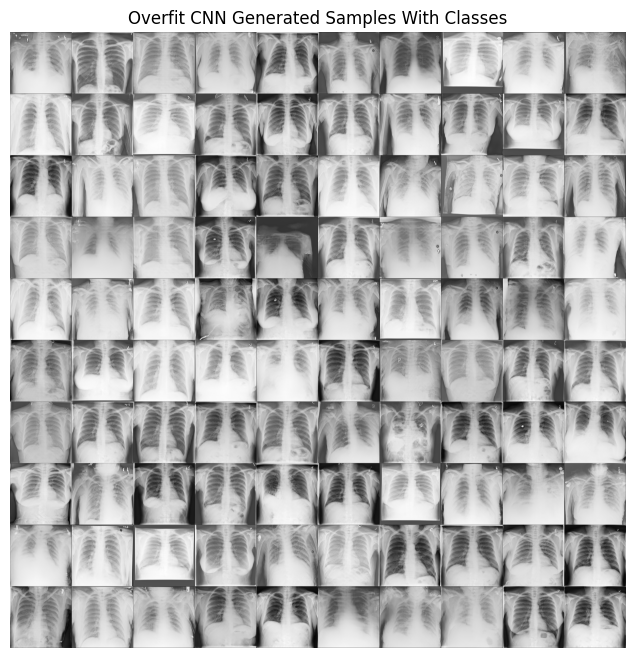

In [14]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(samples, nrow=4, title="Generated Samples"):
  samples_gray = samples.mean(dim=1, keepdim=True) # average channels for grayscale
  grid = vutils.make_grid(samples_gray, nrow=nrow, normalize=True, scale_each=True)
  img_np = grid.permute(1, 2, 0).cpu().numpy()

  plt.figure(figsize=(8,8))
  plt.imshow(img_np)
  plt.axis('off')
  plt.title(title)
  plt.show()

  return samples

images = show_images(candidates, nrow=10, title="Overfit CNN Generated Samples With Classes")

## Validate method

Overfit CNN with distinctive features (shape overlays)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.amp import autocast, GradScaler
import torch.fft

class FineTuneGeneratorResNetClasses:
    def __init__(self, generator, model, device='cpu'):
        self.G = generator.train().to(device)
        self.model = model.eval().to(device)
        self.device = device

        # Select layers
        self.bn_layers = [n for n, m in self.model.named_modules() if isinstance(m, nn.BatchNorm2d)]
        self.feature_layers = ['layer4.1.conv2']
        self.hooked = list(set(self.bn_layers + self.feature_layers))
        self.activations = {}

        # Register hooks
        for name, module in self.model.named_modules():
            if name in self.hooked:
                module.register_forward_hook(self._make_hook(name))

        # Store BN stats
        self.bn_targets = {
            name: {
                'mean': m.running_mean.clone().detach().to(device),
                'var': m.running_var.clone().detach().to(device)
            }
            for name, m in self.model.named_modules() if isinstance(m, nn.BatchNorm2d)
        }

    def _make_hook(self, name):
        def hook(module, input, output):
            self.activations[name] = output
        return hook

    @staticmethod
    def total_variation(x):
        # Encourage spatial smoothness
        dh = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]).mean()
        dw = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]).mean()
        return dh + dw

    def train(self, steps=3000, z_dim=512, batch_size=16, lr=1e-5,
                w_bn=1.0, w_feat=1.0, w_tv=1e-5, w_logits=1.0):

        optimizer = optim.Adam(self.G.parameters(), lr=lr)
        scaler=GradScaler()

        for step in range(1, steps+1):
            self.activations.clear()
            optimizer.zero_grad()

            # Randomly initialize latent
            z = torch.randn(batch_size, z_dim, device=self.device)
            # Chunk into 2 classes for binary classification
            z0, z1 = z.chunk(2)

            with autocast('cuda'):
              # Pass through GAN
              imgs0 = self.G(z0)
              imgs1 = self.G(z1)
              imgs = torch.cat([imgs0, imgs1], dim=0)
              imgs_resized = F.interpolate(imgs, size=(224, 224), mode='bilinear', align_corners=False) # target model expects 224x224

              # Forward through target model
              outputs = self.model(imgs_resized)

              loss = 0.0

              # BN matching
              for name in self.bn_layers:
                  feat = self.activations.get(name)
                  if feat is None:
                      continue
                  mean = feat.mean((0, 2, 3))
                  var = feat.var((0, 2, 3), unbiased=False)
                  target = self.bn_targets[name]
                  loss += w_bn * (F.mse_loss(mean, target['mean']) + F.mse_loss(var, target['var']))

              # Feature stats matching
              for name in self.feature_layers:
                  feat = self.activations.get(name)
                  if feat is None:
                      continue
                  mean_f = feat.mean((0, 2, 3))
                  var_f = feat.var((0, 2, 3), unbiased=False)
                  loss += w_feat * ((mean_f ** 2).mean() + ((var_f - 1) ** 2).mean())

              # Logit matching loss (max confidence for each class)
              logits0 = outputs[:batch_size // 2].view(-1)
              logits1 = outputs[batch_size // 2:].view(-1)

              target0 = torch.zeros_like(logits0) # Encourage 0s for first half, 1s for second half
              target1 = torch.ones_like(logits1)
              logit_loss = F.binary_cross_entropy_with_logits(logits0, target0) + \
                          F.binary_cross_entropy_with_logits(logits1, target1)

              loss += w_logits * logit_loss

              # Total variation
              loss += w_tv * self.total_variation(imgs)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if step % 100 == 0 or step == 1:
                print(f"Step {step}/{steps}, Loss: {loss.item():.4f}")

        return self.G

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
import torch
import torch.nn as nn

cnn_overfit = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
features = cnn_overfit.fc.in_features
cnn_overfit.fc = nn.Linear(features, 1)
cnn_overfit.load_state_dict(torch.load('target_models/models/chest2d_cnn_overfit_feats_cpu.pt'))

<All keys matched successfully>

In [ ]:
gen_feats = FineTuneGeneratorResNetClasses(generator=gan, model=cnn_overfit, device=device)
trained_gen_feats = gen_feats.train(steps=2500, batch_size=8, lr=1e-5)

Step 1/2500, Loss: 14.5858
Step 100/2500, Loss: 14.8590
Step 200/2500, Loss: 13.9825
Step 300/2500, Loss: 14.0588
Step 400/2500, Loss: 14.0669
Step 500/2500, Loss: 13.5284
Step 600/2500, Loss: 13.2359
Step 700/2500, Loss: 13.4531
Step 800/2500, Loss: 13.1156
Step 900/2500, Loss: 12.9202
Step 1000/2500, Loss: 12.6117
Step 1100/2500, Loss: 12.5784
Step 1200/2500, Loss: 12.5724
Step 1300/2500, Loss: 12.5687
Step 1400/2500, Loss: 12.5670
Step 1500/2500, Loss: 12.4877
Step 1600/2500, Loss: 12.4825
Step 1700/2500, Loss: 12.8164
Step 1800/2500, Loss: 12.2322
Step 1900/2500, Loss: 12.3151
Step 2000/2500, Loss: 12.2241
Step 2100/2500, Loss: 12.4538
Step 2200/2500, Loss: 11.9910
Step 2300/2500, Loss: 12.8670
Step 2400/2500, Loss: 12.0412
Step 2500/2500, Loss: 12.2059


In [ ]:
# Save model

torch.save(trained_gen_feats.state_dict(), "cnn_feats_finetuned_gen.pt")

In [ ]:
candidates = sample_images(trained_gen_feats, z_dim=512, num_samples=100, device=device)

In [ ]:
# Save tensors

torch.save(candidates, 'cnn_feats_cand.pt')

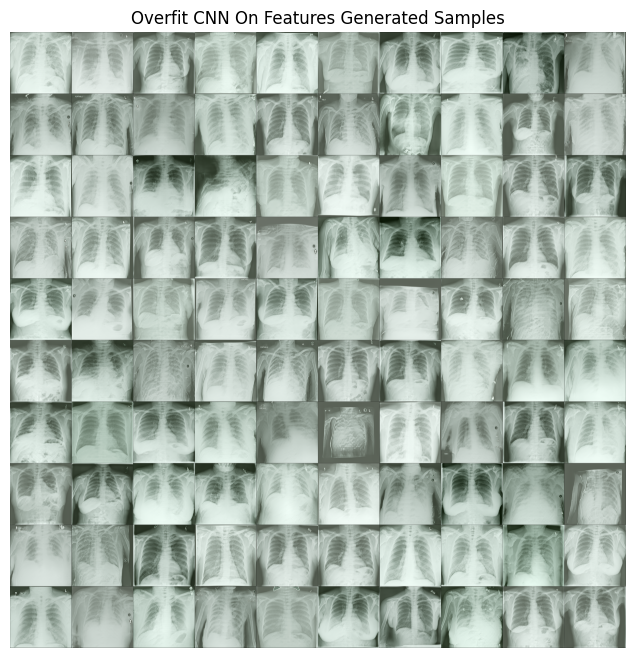

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(samples, nrow=4, title="Generated Samples"):
  samples_gray = samples.mean(dim=1, keepdim=True) # average channels for grayscale
  grid = vutils.make_grid(samples, nrow=nrow, normalize=True, scale_each=True)
  img_np = grid.permute(1, 2, 0).cpu().numpy()

  plt.figure(figsize=(8,8))
  plt.imshow(img_np)
  plt.axis('off')
  plt.title(title)
  plt.show()

  return samples

images = show_images(candidates, nrow=10, title="Overfit CNN On Features Generated Samples")

## ViT

Slightly different strategy compared to CNN given different architecture:
- BatchNorm -> LayerNorm
- Features -> Patch embeddings or token outputs
- Attention weights
- Logits = logits

In [ ]:
# Load model
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch.nn as nn

vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
in_features = vit.heads.head.in_features
vit.heads.head = nn.Linear(in_features, 1)
vit.load_state_dict(torch.load('target_models/models/chest2d_vit_cpu.pt'))
vit.eval().to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.amp import autocast, GradScaler

class FineTuneGeneratorViT:
    def __init__(self, generator, model, device='cpu'):
        self.G = generator.train().to(device)
        self.model = model.eval().to(device)
        self.device = device

        # Select layers
        self.hooked = {
            'encoder.encoder_layer_5.self_attention': None, # attention weights
            'encoder.encoder_layer_5.ln_1': None, # LayerNorm activations
            'encoder': None # CLS token
        }
        self.activations = {}

        # Register hooks
        for name, module in self.model.named_modules():
            if name in self.hooked:
                module.register_forward_hook(self._make_hook(name))

    def _make_hook(self, name):
        def hook(module, input, output):
            self.activations[name] = output
        return hook

    @staticmethod
    def total_variation(x):
        # Encourage spatial smoothness
        dh = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]).mean()
        dw = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]).mean()
        return dh + dw

    def attention_entropy(self, attn):
        # Encourages attention maps to be confident
        ent = - (attn * (attn * 1e-8).log()).sum(dim=-1).mean()
        return ent

    def attention_diversity(self, attn):
        # Encourage heads to be different: pairwise cosine between heads
        heads = attn.flatten(2)
        heads = F.normalize(heads, dim=1)
        sim = torch.einsum('bhk,bjk->bhj', heads, heads)
        diversity = sim.mean() # lower = better diversity
        return diversity

    def train(self, steps=3000, z_dim=512, batch_size=16, lr=1e-5,
                w_ln=1.0, w_cls=1.0, w_tv=1e-5, w_logits=1.0,
                w_attn_ent=1.0, w_attn_div=1.0):

        optimizer = optim.Adam(self.G.parameters(), lr=lr)
        scaler=GradScaler()

        for step in range(1, steps+1):
            self.activations.clear()
            optimizer.zero_grad()

            # Randomly initialize latent
            z = torch.randn(batch_size, z_dim, device=self.device)
            # Chunk into 2 classes for binary classification
            z0, z1 = z.chunk(2)

            with autocast('cuda'):
                # Pass through GAN
                imgs0 = self.G(z0)
                imgs1 = self.G(z1)
                imgs = torch.cat([imgs0, imgs1], dim=0)
                imgs_resized = F.interpolate(imgs, size=(224, 224), mode='bilinear', align_corners=False) # target model expects 224x224

                # Forward through target model
                outputs = self.model(imgs_resized)

                loss = 0.0

                # CLS token loss
                cls_out = self.activations.get('encoder')
                if cls_out is not None:
                    cls_token = cls_out[:, 0, :]
                    loss += w_cls * (cls_token ** 2).mean()

                # LayerNorm stat loss
                ln_out = self.activations.get('encoder.encoder_layer_5.ln_1')
                if ln_out is not None:
                    mean_ln = ln_out.mean(dim=0)
                    var_ln = ln_out.var(dim=0, unbiased=False)
                    loss += w_ln * ((mean_ln ** 2).mean() + ((var_ln - 1) ** 2).mean())

                # Attention entropy
                attn_out = self.activations.get('encoder.encoder_layer_5.self_attention')
                if attn_out is not None and isinstance(attn_out, tuple):
                    attn_weights = attn_out[1] if len(attn_out) > 1 else attn_out[0]
                else:
                    attn_weights = attn_out

                if attn_weights is not None:
                    loss -= w_attn_ent * self.attention_entropy(attn_weights) # negative to minimize entropy
                    loss += w_attn_div * self.attention_diversity(attn_weights)

                # Logit matching loss (max confidence for each class)
                logits0 = outputs[:batch_size // 2].view(-1)
                logits1 = outputs[batch_size // 2:].view(-1)

                target0 = torch.zeros_like(logits0) # Encourage 0s for first half, 1s for second half
                target1 = torch.ones_like(logits1)
                logit_loss = F.binary_cross_entropy_with_logits(logits0, target0) + \
                            F.binary_cross_entropy_with_logits(logits1, target1)

                loss += w_logits * logit_loss

                # Total variation
                loss += w_tv * self.total_variation(imgs)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if step % 100 == 0 or step == 1:
                print(f"Step {step}/{steps}, Loss: {loss.item():.4f}")

        return self.G

In [12]:
gen_vit = FineTuneGeneratorViT(generator=gan, model=vit, device=device)
trained_gen_vit = gen_vit.train(steps=2500, batch_size=8, lr=1e-5)

Step 1/2500, Loss: 2.1072
Step 100/2500, Loss: 1.9115
Step 200/2500, Loss: 1.8969
Step 300/2500, Loss: 2.2258
Step 400/2500, Loss: 2.2026
Step 500/2500, Loss: 2.1021
Step 600/2500, Loss: 1.7352
Step 700/2500, Loss: 1.3345
Step 800/2500, Loss: 1.5161
Step 900/2500, Loss: 1.9172
Step 1000/2500, Loss: 2.0950
Step 1100/2500, Loss: 1.7107
Step 1200/2500, Loss: 2.2372
Step 1300/2500, Loss: 2.0850
Step 1400/2500, Loss: 1.5282
Step 1500/2500, Loss: 2.0405
Step 1600/2500, Loss: 1.9491
Step 1700/2500, Loss: 2.3718
Step 1800/2500, Loss: 1.6222
Step 1900/2500, Loss: 1.8028
Step 2000/2500, Loss: 1.7257
Step 2100/2500, Loss: 1.9752
Step 2200/2500, Loss: 1.2434
Step 2300/2500, Loss: 1.3332
Step 2400/2500, Loss: 1.8405
Step 2500/2500, Loss: 1.6974


In [13]:
# Save model

torch.save(trained_gen_vit.state_dict(), "vit_finetuned_gen.pt")

In [14]:
candidates = sample_images(trained_gen_vit, z_dim=512, num_samples=100, device=device)

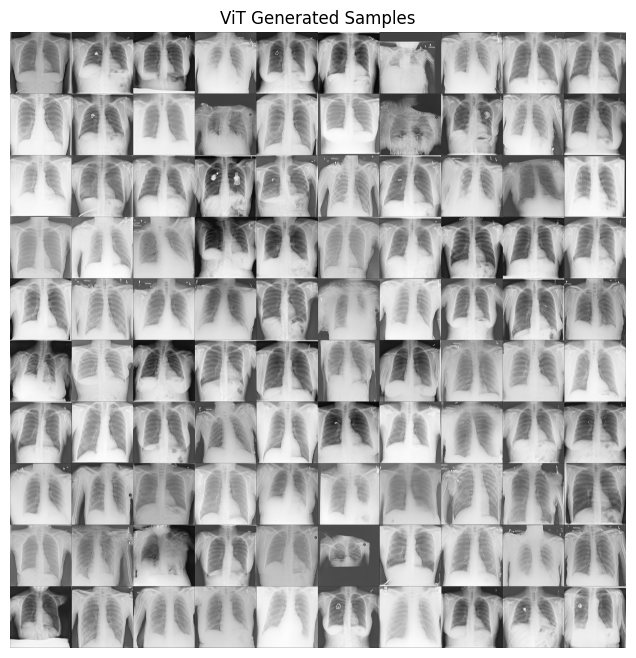

In [15]:
images = show_images(candidates, nrow=10, title="ViT Generated Samples")

In [16]:
# Save tensor

torch.save(candidates, 'vit_gen_cand.pt')

## Overfit ViT

In [17]:
# Load model
from torchvision.models import vit_b_16, ViT_B_16_Weights

vit_overfit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
in_features = vit_overfit.heads.head.in_features
vit_overfit.heads.head = nn.Linear(in_features, 1)
vit_overfit.load_state_dict(torch.load('target_models/models/chest2d_vit_overfit_cpu.pt'))
vit_overfit.eval().to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [18]:
gen_vit = FineTuneGeneratorViT(generator=gan, model=vit_overfit, device=device)
trained_gen_vit = gen_vit.train(steps=2500, batch_size=8, lr=1e-5)

Step 1/2500, Loss: 2.2023
Step 100/2500, Loss: 2.0774
Step 200/2500, Loss: 2.7411
Step 300/2500, Loss: 3.4576
Step 400/2500, Loss: 3.1813
Step 500/2500, Loss: 1.8437
Step 600/2500, Loss: 1.7610
Step 700/2500, Loss: 4.0708
Step 800/2500, Loss: 1.3604
Step 900/2500, Loss: 3.7402
Step 1000/2500, Loss: 3.2721
Step 1100/2500, Loss: 3.5439
Step 1200/2500, Loss: 3.4990
Step 1300/2500, Loss: 1.8530
Step 1400/2500, Loss: 3.0398
Step 1500/2500, Loss: 2.1875
Step 1600/2500, Loss: 1.3672
Step 1700/2500, Loss: 2.8237
Step 1800/2500, Loss: 1.3168
Step 1900/2500, Loss: 1.8031
Step 2000/2500, Loss: 2.8400
Step 2100/2500, Loss: 1.4078
Step 2200/2500, Loss: 1.3986
Step 2300/2500, Loss: 1.2868
Step 2400/2500, Loss: 2.2883
Step 2500/2500, Loss: 2.9899


In [19]:
# Save model

torch.save(trained_gen_vit.state_dict(), "vit_overfit_finetuned_gen.pt")

In [20]:
candidates = sample_images(trained_gen_vit, z_dim=512, num_samples=100, device=device)

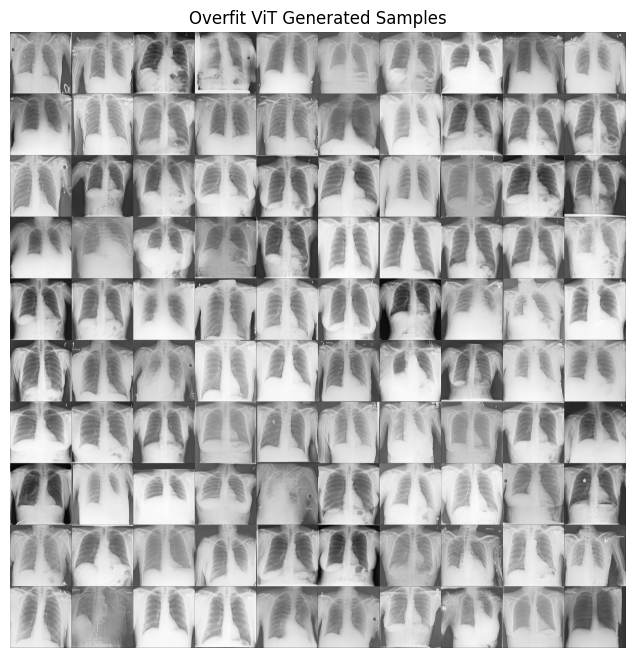

In [21]:
images = show_images(candidates, nrow=10, title="Overfit ViT Generated Samples")

In [22]:
# Save tensor

torch.save(candidates, 'vit_overfit_cand.pt')